In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt
import random

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
filename = r'../data/olhs_run1.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Initial Design (OLHS)', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='feasibility', header=[0,1], index_col=[0])

In [3]:
x_pd

Group ID Block 1 (Hydrophobic) [End Segment]                    \
#                                 Block Size LA:SA Ratio (%LA)   
1                                4105.263158         57.894737   
2                                2421.052632         84.210526   
3                                4947.368421         47.368421   
4                                8315.789474          5.263158   
5                                2842.105263         89.473684   
6                                7473.684211         42.105263   
7                                6210.526316         52.631579   
8                                7052.631579         31.578947   
9                                3684.210526         26.315789   
10                               7894.736842         73.684211   
11                               9157.894737        100.000000   
12                               2000.000000          0.000000   
13                               8736.842105         63.157895   
14                               4526.315789         68.421053   
15                               3263.157895         36.842105   
16                               9578.947368         21.052632   
17                               6631.578947         15.789474   
18                               5368.421053         10.526316   
19                              10000.000000         94.736842   
20                               5789.473684         78.947368   

Group ID                            Block 2 (Hydrophilic) [Middle Segment]  \
#        [Am]:[SA+LA] Ratio (%[AM])                             Block Size   
1                         40.000000                            5000.000000   
2                         23.157895                           11315.789474   
3                         16.842105                            5526.315789   
4                         37.894737                           10789.473684   
5                          2.105263                            9736.842105   
6                          0.000000                           15000.000000   
7                         25.263158                           13947.368421   
8                         10.526316                            6052.631579   
9                         12.631579                            6578.947368   
10                        29.473684                           13421.052632   
11                        27.368421                            8157.894737   
12                        14.736842                           12894.736842   
13                         8.421053                            9210.526316   
14                        31.578947                           14473.684211   
15                        35.789474                           11842.105263   
16                        21.052632                            8684.210526   
17                         6.315789                           12368.421053   
18                        18.947368                            7631.578947   
19                         4.210526                           10263.157895   
20                        33.684211                            7105.263158   

Group ID                                        \
#        Am:IonM Ratio (%Am) LA:SA Ratio (%LA)   
1                  91.578947         52.631579   
2                  80.000000         31.578947   
3                  86.315789         10.526316   
4                  85.263158         21.052632   
5                  95.789474         73.684211   
6                  88.421053         36.842105   
7                  96.842105         94.736842   
8                  82.105263        100.000000   
9                  97.894737         26.315789   
10                 83.157895         57.894737   
11                 92.631579         47.368421   
12                 87.368421         42.105263   
13                 89.473684         15.789474   
14                 98.947368          0.000000   
15                 90.526316  

In [4]:
y_pd

Group ID,Manufacturability
#,--
1,1
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,1


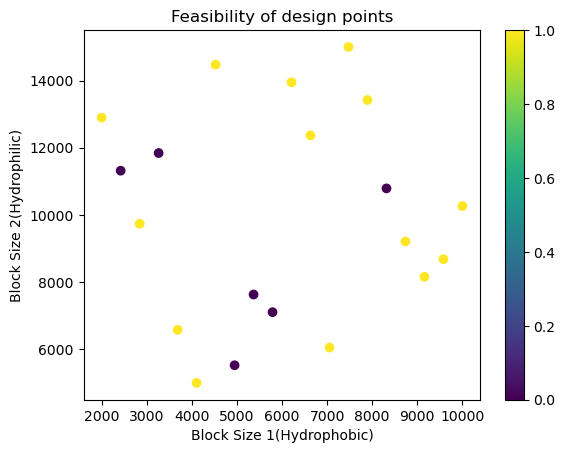

In [5]:
# plot - 2D plot for 8D points; not helpful
x1_plt = x_pd['Block 1 (Hydrophobic) [End Segment]', 'Block Size'].values
x2_plt = x_pd['Block 2 (Hydrophilic) [Middle Segment]', 'Block Size'].values
plt.scatter(x1_plt, x2_plt, c = y_pd['Manufacturability', '--'].values)
plt.xlabel('Block Size 1(Hydrophobic)')
plt.ylabel('Block Size 2(Hydrophilic)')
plt.title('Feasibility of design points')
plt.colorbar()
plt.show()

In [6]:
#normalize input features - unit hypercube
# xmin = x_pd.min(axis=0)
# xmax = x_pd.max(axis=0)
# x_pd_normal = (x_pd - xmin)/(xmax - xmin)
xmeans = x_pd.mean(axis=0)
xstddv = x_pd.std(axis=0)
x_pd_normal = (x_pd - xmeans)/xstddv
x_pd = x_pd_normal

In [7]:
# select a random point as a validation point
# validation_idx = random.choice(x_pd.index.to_list()) #group id of validation point
# validation_idx = 1
#80:20 split for train-validation data - manual selection
validation_idx = [1, 7, 15]

train_x_pd = x_pd.drop(validation_idx)
train_y_pd = y_pd.drop(validation_idx)

test_x_pd = x_pd.loc[validation_idx, :]
test_y_pd = y_pd.loc[validation_idx, :]

In [8]:
#make torch tensors
train_x = torch.tensor(train_x_pd.values, dtype=torch.long)
train_y = torch.tensor(train_y_pd.values, dtype=torch.long).squeeze()

# test_x = torch.tensor(test_x_pd.values, dtype=torch.long)
# test_y = torch.tensor(test_y_pd.values, dtype=torch.long).squeeze()
test_x = torch.tensor(x_pd.values, dtype=torch.long)
test_y = torch.tensor(y_pd.values, dtype=torch.long).squeeze()

In [9]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False, alpha_epsilon=1e-4)

In [11]:
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [12]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  ' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            # model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 12.778   lengthscale: 0.693  
Iter 11/50 - Loss: 10.804   lengthscale: 1.222  
Iter 21/50 - Loss: 10.037   lengthscale: 1.262  
Iter 31/50 - Loss: 9.391   lengthscale: 0.984  
Iter 41/50 - Loss: 8.887   lengthscale: 0.742  


In [13]:
model.eval() # calculates latent variable 'f' (logits) bcoz we used DirichletGP
likelihood.eval()

# test_x = torch.tensor(test_x.numpy().reshape((1,8)))

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)   # gives a multi-variate normal distribution at each test_x point
                                # number of variables = number of classes
    post_pred = likelihood(test_dist)
    pred_means = post_pred.mean  # loc method comes from pytorch distrubutions; is equal to mean 
    pred_stddevs = post_pred.stddev

/Users/gouravkumbhojkar/miniconda3/envs/myenv/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [14]:
# calculate expected value of class probabilites; this is done by sampling 256 points and taking average
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

In [15]:
# print("validation idx - ", validation_idx)
print("Probability of being in class 0 (infeasible) = ", probabilities[0].numpy())
print("Probability of being in class 1 (feasible) = ", probabilities[1].numpy())

Probability of being in class 0 (infeasible) =  [4.0038440e-01 9.7921973e-01 9.7382092e-01 9.8655182e-01 4.1667842e-03
 1.7682714e-03 3.0593851e-01 2.1404671e-02 9.4481315e-03 4.2284457e-03
 2.0052942e-03 2.0538809e-02 4.6097967e-03 2.5741879e-03 4.8812684e-01
 3.6331029e-03 6.2005594e-03 9.8075253e-01 4.8856036e-04 9.8486882e-01]
Probability of being in class 1 (feasible) =  [0.5996156  0.02078027 0.02617907 0.01344812 0.9958333  0.9982318
 0.6940614  0.9785953  0.99055195 0.9957716  0.99799466 0.9794612
 0.9953902  0.9974258  0.5118731  0.9963668  0.99379945 0.01924744
 0.9995115  0.01513122]


In [17]:
pred_means.max(0)[1]

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0])

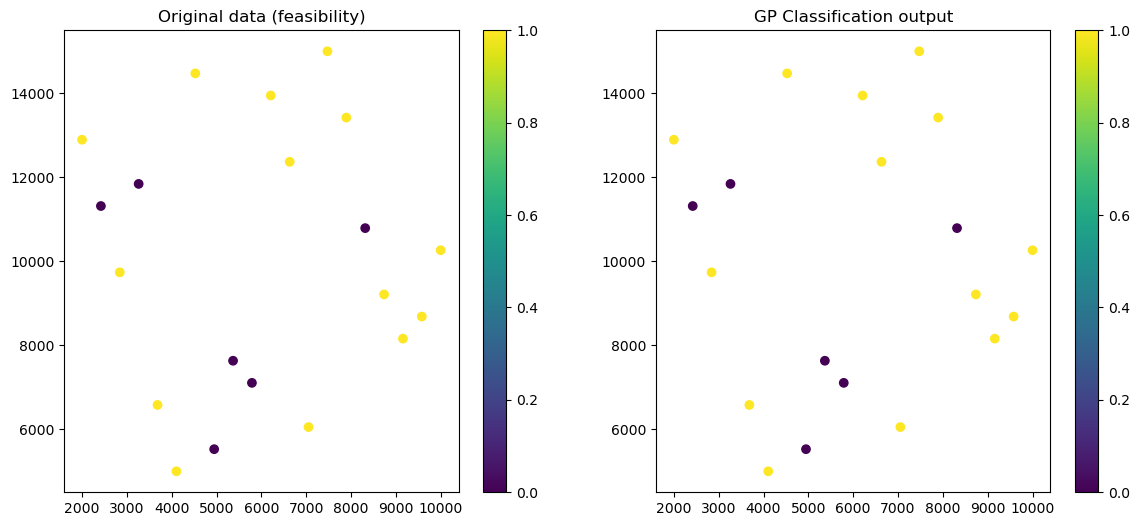

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

im=ax[0].scatter(x1_plt, x2_plt, c = y_pd['Manufacturability', '--'].values)
ax[0].set_title('Original data (feasibility)')
fig.colorbar(im, ax=ax[0])

im =ax[1].scatter(x1_plt, x2_plt, c = pred_means.max(0)[1])
ax[1].set_title('GP Classification output')
fig.colorbar(im, ax=ax[1])

plt.show()

**Comment on alpha-epsilon**

Dirichlet classification prior needs a parameter $\alpha_{\epsilon}$ which is user defined (default is 0.01). Performance of the classification model depends on this parameter. In the original paper, authors say that 0.01 worked for some of the models, which showed a dip the graph of performance-vs-alpha near 0.01. But they also showed that some datasets showed a monotonic improvement in performance as alpha is reduced.
Authors suggested that alpha should be determined by cross-validation.